In [2]:
!pip install transformers[sentencepiece] datasets rouge_score py7zr -q

In the first line of code, we install different packages needed for our summarization task. 

transformers : Used to import tokenizers and models

sentencepiece : It is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training.

datasets : used to import cnn/daily-mail dataset

py7zr : py7zr is a library and utility to support 7zip archive compression, decompression, encryption and decryption. 




In [3]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt

import pandas as pd
from datasets import load_dataset, load_metric
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

#importing the required datasets, models and tokenizers from our installed packages. 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", version="3.0.0")

print(f"Features in cnn_dailymail : {dataset['train'].column_names}")

# Here, we load the cnn/daily-mail dataset ; from the hugging face library. 

  0%|          | 0/3 [00:00<?, ?it/s]

Features in cnn_dailymail : ['article', 'highlights', 'id']


In [5]:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 4051):

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


In [6]:
sample_text = dataset["train"][1]["article"][:1000]
#Due to GPU constraints,I am considering only the first 1000 articles.
#Here, we are storing the generated summaries of each model in a dictionary
summaries = {}

In [7]:
def baseline_summary_three_sent(text):
    return "\n".join(sent_tokenize(text)[:3])

In [8]:
summaries['baseline'] = baseline_summary_three_sent(sample_text)

summaries['baseline']

'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."'

In [9]:

pipe = pipeline("summarization", model="facebook/bart-large")
pipe_out = pipe(sample_text)

# Here, we are using the BART-Large Model for our summarization task. 
#A detailed information about the same can be found in the readme file.




/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


In [10]:
pipe_out

[{'summary_text': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O\'Brien takes us inside a jail where many of the inmates are mentally ill. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoid'}]

In [11]:
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [12]:
summaries["bart"]

'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes us inside a jail where many of the inmates are mentally ill. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."\nHere, inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear in court.\nMost often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoid'

#Using the ROGUE Metric



In [13]:
rouge_metric = load_metric('rouge')

<ipython-input-13-90542a62301a>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')


In [14]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

reference = dataset['train'][1]['highlights']

records = []

for model_name in summaries:
    rouge_metric.add(prediction = summaries[model_name], reference = reference )
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )
    print('rouge_dict ', rouge_dict )
    records.append(rouge_dict)

pd.DataFrame.from_records(records, index = summaries.keys() )

rouge_dict  {'rouge1': 0.365079365079365, 'rouge2': 0.14516129032258066, 'rougeL': 0.20634920634920634, 'rougeLsum': 0.2857142857142857}
rouge_dict  {'rouge1': 0.35374149659863946, 'rouge2': 0.09655172413793102, 'rougeL': 0.14965986394557823, 'rougeLsum': 0.3129251700680272}


,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
bart,0.353741,0.096552,0.149660,0.312925


In [15]:
def calculate_metric_on_baseline_test_ds(dataset, metric, column_text = 'article', column_summary = 'highlights' ):
    summaries = [baseline_summary_three_sent(text) for text in dataset[column_text] ]

    metric.add_batch(predictions = summaries, references = dataset[column_summary] )

    score = metric.compute()
    return score

In [16]:
test_sampled = dataset['train'].shuffle(seed = 42).select(range(1000))

score = calculate_metric_on_baseline_test_ds(test_sampled, rouge_metric )

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame.from_dict(rouge_dict, orient = 'index' , columns = ['baseline'] ).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.25393,0.100672,0.16604,0.23201


In [17]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def calculate_metric_on_test_ds(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        
        # Finally, we decode the generated texts, 
        # replace the <n> token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "facebook/bart-large"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_bart = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

score = calculate_metric_on_test_ds(test_sampled, rouge_metric, 
                                   model_bart, tokenizer, batch_size=5)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

# At the end, we compute and return the ROUGE scores.
pd.DataFrame(rouge_dict, index=["bart"])

  0%|          | 0/200 [00:00<?, ?it/s]

Because Google colab doesn't have Enough GPU support, we will not be able to calculate the rogue score using colab. 


Using large GPU's BART has a very good rogue metric as follows
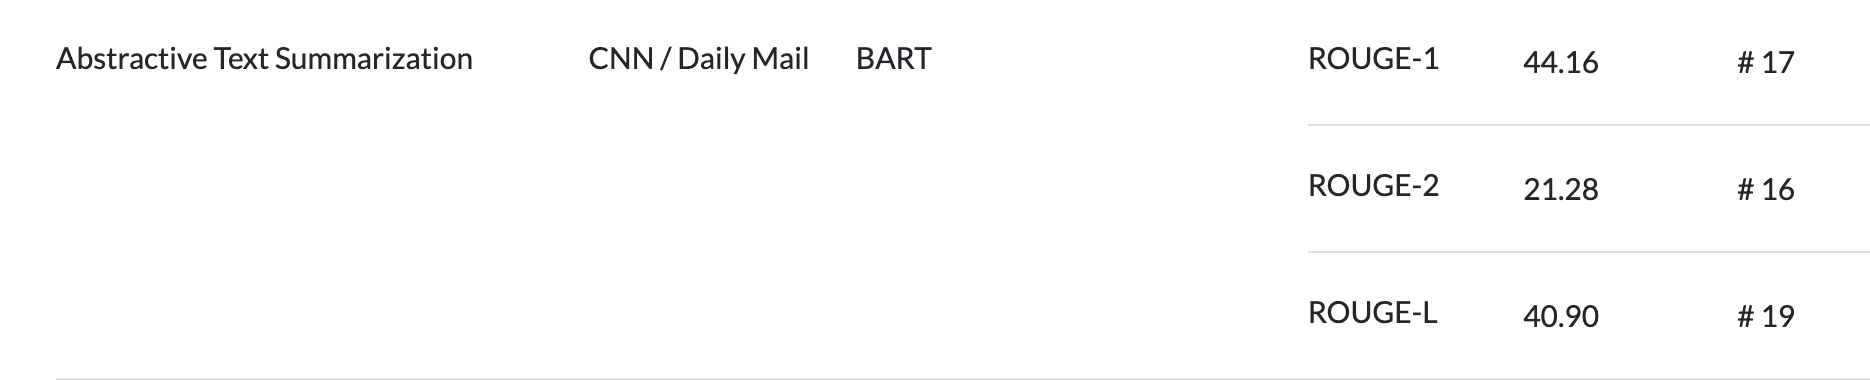
